1) https://www.kaggle.com/fabiendaniel/elo-world
2) https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/

In [1]:
from fastai.learner import *
from fastai.column_data import *
from fastai.structured import *

D:\python\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
PATH=Path('data/elo')
# C drive path
# PATH1 = Path('c:/data/')

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [15]:
new_transactions = pd.read_csv(f'{PATH}/new_merchant_transactions.csv', parse_dates=['purchase_date'])


In [18]:
historical_transactions = pd.read_csv(f'{PATH}/his_trans.csv', parse_dates=['purchase_date'])

In [19]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [20]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

In [21]:
historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [22]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

In [23]:
train = read_data(f'{PATH}/train.csv')
test = read_data(f'{PATH}/test.csv')

In [24]:
target = train['target']
del train['target']

In [25]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [26]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

In [27]:
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [28]:
agg_fun = {'authorized_flag': ['sum', 'mean']}

In [29]:
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

In [30]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [31]:
def aggregate_transactions(history):
    history.loc[:,'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).astype(np.int64)*1e-9
    agg_func = {
        'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df =(history.groupby('card_id')
        .size()
        .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history,on='card_id',how='left')
    return agg_history

In [32]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,...,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,...,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,9.514286
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,...,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,9.333333
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,...,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,9.750000
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,...,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,13.666667
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,9.285714


In [33]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,...,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,9.701754
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,...,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,9.350000
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,...,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,9.709677
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,...,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,13.513228
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,...,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,9.554745


In [34]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,10.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,9.230769
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,9.000000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,13.064516
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,9.727273


In [35]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id','month_lag'])
    
    agg_func ={
          'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
          'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
    }
    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)
    print(intermediate_group[:5])
    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [36]:
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]

           card_id  month_lag  purchase_amount_count  purchase_amount_sum  \
0  C_ID_00007093c1        -11                      3            -1.786923   
1  C_ID_00007093c1        -10                      3            -1.594583   
2  C_ID_00007093c1         -9                      4             0.023877   
3  C_ID_00007093c1         -8                      6            -2.359658   
4  C_ID_00007093c1         -7                      2            -1.206809   

   purchase_amount_mean  purchase_amount_min  purchase_amount_max  \
0             -0.595641            -0.671775            -0.557574   
1             -0.531528            -0.671775            -0.311139   
2              0.005969            -0.596447             0.307953   
3             -0.393276            -0.728876             0.004418   
4             -0.603405            -0.610167            -0.596643   

   purchase_amount_std  installments_count  installments_sum  \
0             0.065934                   3                

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-5.500000,3.605551,2.916667,1.621354,-1.200164,0.999049,-0.431906,0.260478,-0.613764,...,3.750000,3.107908,1.176389,0.326634,1.000000,0.000000,1.500000,0.797724,0.355262,0.480551
1,C_ID_0001238066,-1.000000,1.414214,1.500000,0.707107,-0.894964,0.421890,-0.596643,0.000000,-0.596643,...,1.500000,0.707107,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
2,C_ID_0001506ef0,-3.333333,4.163332,1.333333,0.577350,-0.968594,0.395645,-0.731020,0.015849,-0.732397,...,0.333333,0.577350,0.166667,0.288675,0.000000,0.000000,0.333333,0.577350,0.707107,NaN
3,C_ID_0001793786,-3.833333,2.316607,4.500000,1.974842,-1.970890,2.037261,-0.423501,0.392159,-0.676499,...,0.833333,0.983192,0.291667,0.400520,0.166667,0.408248,0.500000,0.547723,0.179558,0.279244
4,C_ID_000183fdda,-5.000000,1.414214,3.500000,3.535534,-0.470690,0.344856,-0.376174,0.478523,-0.579708,...,9.500000,12.020815,2.000000,1.414214,1.000000,0.000000,3.500000,3.535534,2.366432,NaN
5,C_ID_00024e244b,-5.000000,4.000000,2.428571,1.397276,-1.186659,1.210810,-0.558085,0.326273,-0.607249,...,0.714286,1.112697,0.297619,0.419041,0.142857,0.377964,0.428571,0.534522,0.269338,0.312603
6,C_ID_0002709b5a,-7.250000,5.057997,1.500000,1.000000,-0.929675,0.699316,-0.604163,0.156637,-0.616865,...,2.750000,2.362908,2.250000,2.500000,2.250000,2.500000,2.250000,2.500000,0.000000,NaN
7,C_ID_00027503e2,-4.000000,2.915476,3.600000,1.516575,-2.669652,1.128393,-0.741249,0.002457,-0.742989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-6.500000,3.535534,1.000000,0.000000,-0.617958,0.093896,-0.617958,0.093896,-0.617958,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,-3.666667,3.559026,2.500000,1.516575,-1.547448,0.910264,-0.641704,0.080430,-0.655965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

In [52]:
test.to_csv('test.csv')
train['target'] = target
# train.to_csv('train.csv')
# del train['target']

In [4]:
unimportant_features = [
    'auth_category_2_1.0_mean',
    'auth_category_2_2.0_mean',
    'auth_category_2_3.0_mean',
    'auth_category_2_5.0_mean',
    'hist_category_2_3.0_mean',
    'hist_category_2_4.0_mean',
    'hist_category_2_5.0_mean',
    'hist_category_3_A_mean',
    'hist_installments_min',
    'hist_installments_std',
    'hist_month_lag_std',
    'hist_purchase_amount_max',
    'hist_purchase_month_max',
    'hist_purchase_month_min',
    'hist_purchase_month_std',
    'installments_min_mean',
    'new_category_2_1.0_mean',
    'new_category_2_2.0_mean',
    'new_category_2_3.0_mean',
    'new_category_2_5.0_mean',
    'new_city_id_nunique',
    'new_installments_std',
    'new_state_id_nunique',
    'purchase_amount_mean_mean'
]
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
features = [f for f in features if f not in unimportant_features]
categorical_feats = [c for c in features if 'feature_' in c]

['elapsed_time', 'hist_transactions_count', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_1.0_mean', 'hist_category_2_2.0_mean', 'hist_category_3_B_mean', 'hist_category_3_C_mean', 'hist_merchant_id_nunique', 'hist_merchant_category_id_nunique', 'hist_state_id_nunique', 'hist_city_id_nunique', 'hist_subsector_id_nunique', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_min', 'hist_purchase_amount_std', 'hist_installments_sum', 'hist_installments_mean', 'hist_installments_max', 'hist_purchase_month_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_mean', 'hist_month_lag_max', 'hist_month_lag_min', 'hist_month_diff_mean', 'auth_transactions_count', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_4.0_mean', 'auth_category_3_A_mean', 'auth_category_3_B_mean', 'auth_category_3_C_mean', 'auth_merchant_id_nunique', 'auth_merchant_category_id_nunique', 'auth_state_id_nunique', 'a

In [40]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 6,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [41]:
folds = KFold(n_splits=5,shuffle=True,random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_,(trn_idx,val_idx) in enumerate(folds.split(train.values,target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72432	valid_1's rmse: 3.78324
[200]	training's rmse: 3.6634	valid_1's rmse: 3.73777
[300]	training's rmse: 3.6248	valid_1's rmse: 3.71529
[400]	training's rmse: 3.5964	valid_1's rmse: 3.70309
[500]	training's rmse: 3.57455	valid_1's rmse: 3.6956
[600]	training's rmse: 3.55833	valid_1's rmse: 3.69043
[700]	training's rmse: 3.54462	valid_1's rmse: 3.6868
[800]	training's rmse: 3.53143	valid_1's rmse: 3.68428
[900]	training's rmse: 3.52062	valid_1's rmse: 3.68223
[1000]	training's rmse: 3.50993	valid_1's rmse: 3.68039
[1100]	training's rmse: 3.49999	valid_1's rmse: 3.6793
[1200]	training's rmse: 3.4909	valid_1's rmse: 3.67874
[1300]	training's rmse: 3.48204	valid_1's rmse: 3.67829
[1400]	training's rmse: 3.47369	valid_1's rmse: 3.67805
[1500]	training's rmse: 3.4656	valid_1's rmse: 3.67801
[1600]	training's rmse: 3.4567	valid_1's rmse: 3.67766
[1700]	training's rmse: 3.44795	valid_1's rmse: 3.67698
[18

D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.74356	valid_1's rmse: 3.71072
[200]	training's rmse: 3.68034	valid_1's rmse: 3.66892
[300]	training's rmse: 3.64098	valid_1's rmse: 3.64935
[400]	training's rmse: 3.61225	valid_1's rmse: 3.64019
[500]	training's rmse: 3.59133	valid_1's rmse: 3.63476
[600]	training's rmse: 3.57468	valid_1's rmse: 3.63123
[700]	training's rmse: 3.56006	valid_1's rmse: 3.6285
[800]	training's rmse: 3.54719	valid_1's rmse: 3.62614
[900]	training's rmse: 3.53547	valid_1's rmse: 3.62417
[1000]	training's rmse: 3.52454	valid_1's rmse: 3.62279
[1100]	training's rmse: 3.51424	valid_1's rmse: 3.62169
[1200]	training's rmse: 3.50424	valid_1's rmse: 3.62078
[1300]	training's rmse: 3.49554	valid_1's rmse: 3.62014
[1400]	training's rmse: 3.48623	valid_1's rmse: 3.61958
[1500]	training's rmse: 3.47721	valid_1's rmse: 3.61935
[1600]	training's rmse: 3.46829	valid_1's rmse: 3.61916
[1700]	training's rmse: 3.46002	valid_1's rmse: 3.6

D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.74684	valid_1's rmse: 3.68451
[200]	training's rmse: 3.68452	valid_1's rmse: 3.6446
[300]	training's rmse: 3.64596	valid_1's rmse: 3.62648
[400]	training's rmse: 3.6178	valid_1's rmse: 3.61708
[500]	training's rmse: 3.59606	valid_1's rmse: 3.61127
[600]	training's rmse: 3.57859	valid_1's rmse: 3.60704
[700]	training's rmse: 3.56434	valid_1's rmse: 3.60454
[800]	training's rmse: 3.5517	valid_1's rmse: 3.60288
[900]	training's rmse: 3.54098	valid_1's rmse: 3.6016
[1000]	training's rmse: 3.5308	valid_1's rmse: 3.60102
[1100]	training's rmse: 3.5211	valid_1's rmse: 3.60064
[1200]	training's rmse: 3.51076	valid_1's rmse: 3.60055
[1300]	training's rmse: 3.5016	valid_1's rmse: 3.60056
[1400]	training's rmse: 3.49284	valid_1's rmse: 3.6007
Early stopping, best iteration is:
[1290]	training's rmse: 3.50268	valid_1's rmse: 3.60045
fold n°3


D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.69782	valid_1's rmse: 3.88546
[200]	training's rmse: 3.63608	valid_1's rmse: 3.84195
[300]	training's rmse: 3.59804	valid_1's rmse: 3.81985
[400]	training's rmse: 3.57021	valid_1's rmse: 3.80784
[500]	training's rmse: 3.54761	valid_1's rmse: 3.80058
[600]	training's rmse: 3.5305	valid_1's rmse: 3.79589
[700]	training's rmse: 3.51602	valid_1's rmse: 3.7931
[800]	training's rmse: 3.5029	valid_1's rmse: 3.79145
[900]	training's rmse: 3.49048	valid_1's rmse: 3.7899
[1000]	training's rmse: 3.47991	valid_1's rmse: 3.78899
[1100]	training's rmse: 3.47104	valid_1's rmse: 3.78855
[1200]	training's rmse: 3.46199	valid_1's rmse: 3.78794
[1300]	training's rmse: 3.45392	valid_1's rmse: 3.78769
[1400]	training's rmse: 3.44527	valid_1's rmse: 3.78735
[1500]	training's rmse: 3.43706	valid_1's rmse: 3.78671
[1600]	training's rmse: 3.42852	valid_1's rmse: 3.78653
[1700]	training's rmse: 3.42084	valid_1's rmse: 3.7863

D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\python\envs\fastai\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7438	valid_1's rmse: 3.6992
[200]	training's rmse: 3.68014	valid_1's rmse: 3.66039
[300]	training's rmse: 3.63991	valid_1's rmse: 3.6433
[400]	training's rmse: 3.6108	valid_1's rmse: 3.63451
[500]	training's rmse: 3.58857	valid_1's rmse: 3.62864
[600]	training's rmse: 3.57116	valid_1's rmse: 3.62499
[700]	training's rmse: 3.55644	valid_1's rmse: 3.62228
[800]	training's rmse: 3.54317	valid_1's rmse: 3.62075
[900]	training's rmse: 3.5309	valid_1's rmse: 3.61987
[1000]	training's rmse: 3.52075	valid_1's rmse: 3.61899
[1100]	training's rmse: 3.51126	valid_1's rmse: 3.61845
[1200]	training's rmse: 3.50145	valid_1's rmse: 3.61804
[1300]	training's rmse: 3.49235	valid_1's rmse: 3.61788
[1400]	training's rmse: 3.48377	valid_1's rmse: 3.61744
[1500]	training's rmse: 3.47514	valid_1's rmse: 3.61714
[1600]	training's rmse: 3.46725	valid_1's rmse: 3.61722
[1700]	training's rmse: 3.45912	valid_1's rmse: 3.6173


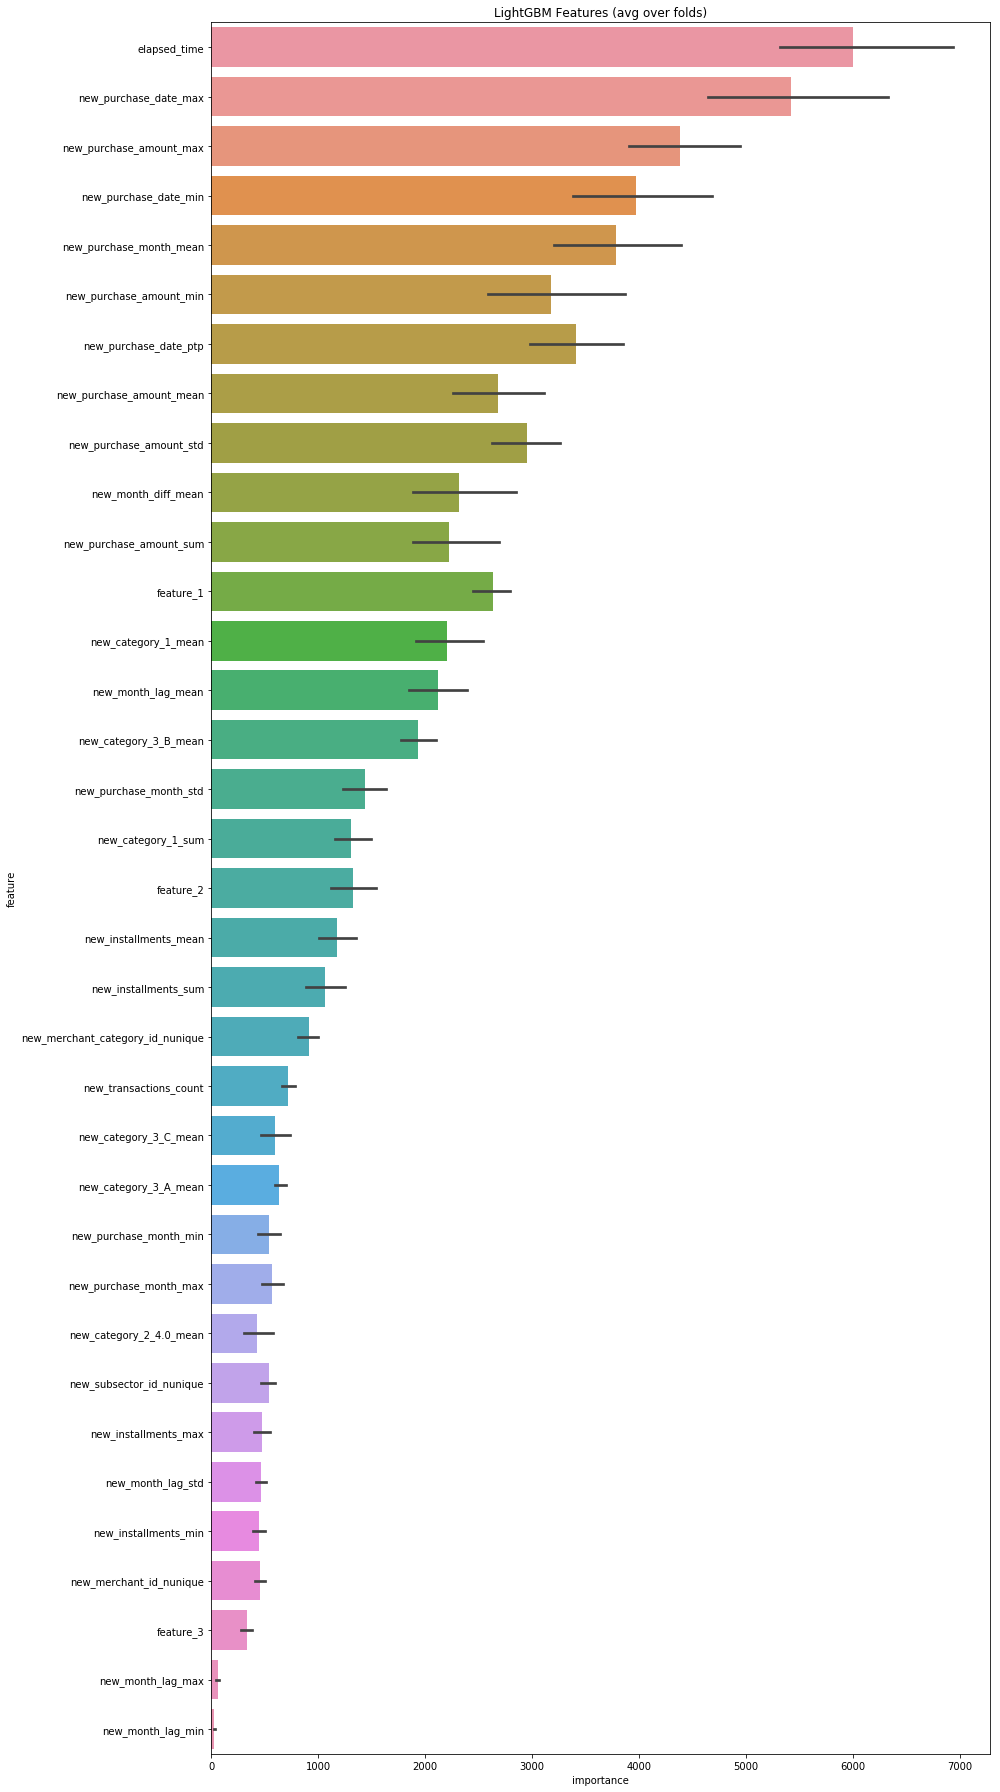

In [38]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [44]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(f'{PATH}\submit_elo.csv', index=False)

## Deep Learning model 

In [6]:
train['target'][:5]

0   -0.820283
1    0.392913
2    0.688056
3    0.142495
4   -0.159749
Name: target, dtype: float64

In [3]:
test = pd.read_csv('test.csv')

train = pd.read_csv('train.csv')

In [8]:
# delete repeated features
# del features[-1]
# del features[:4]
print(features)
print(categorical_feats)

['elapsed_time', 'hist_transactions_count', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_1.0_mean', 'hist_category_2_2.0_mean', 'hist_category_3_B_mean', 'hist_category_3_C_mean', 'hist_merchant_id_nunique', 'hist_merchant_category_id_nunique', 'hist_state_id_nunique', 'hist_city_id_nunique', 'hist_subsector_id_nunique', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_min', 'hist_purchase_amount_std', 'hist_installments_sum', 'hist_installments_mean', 'hist_installments_max', 'hist_purchase_month_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_mean', 'hist_month_lag_max', 'hist_month_lag_min', 'hist_month_diff_mean', 'auth_transactions_count', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_4.0_mean', 'auth_category_3_A_mean', 'auth_category_3_B_mean', 'auth_category_3_C_mean', 'auth_merchant_id_nunique', 'auth_merchant_category_id_nunique', 'auth_state_id_nunique', 'a

In [9]:
dep = 'target'
df_train = train[categorical_feats+features+[dep]].copy()

In [10]:
test[dep] = 0.0
df_test = test[categorical_feats+features+[dep, 'card_id']].copy()

In [11]:
for v in categorical_feats: df_train[v] = df_train[v].astype('category').cat.as_ordered()
apply_cats(df_test, df_train)

In [12]:
for v in features:
    df_train[v] = df_train[v].fillna(0).astype('float32')
    df_test[v] = df_test[v].fillna(0).astype('float32')

In [13]:
samp_size = len(df_train)
df, y, nas, mapper = proc_df(df_train, dep, do_scale=True)

In [14]:
df_test1, _, nas, mapper = proc_df(df_test, dep, do_scale=True,skip_flds=['card_id'],mapper=mapper, na_dict=nas)

In [15]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [16]:
def exp_rmse(y_pred, targ):
#     targ = inv_y(targ)
    pct_var = (targ - y_pred)
    return math.sqrt((pct_var**2).mean())

y_range = (0, 1)

In [17]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds=categorical_feats, bs=128,
                                       test_df=df_test1)

In [18]:
cat_sz = [(c, len(df_train[c].cat.categories)+1) for c in categorical_feats]
cat_sz

[('feature_1', 6), ('feature_2', 4), ('feature_3', 3)]

In [19]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(6, 3), (4, 2), (3, 2)]

In [20]:
m = md.get_learner(emb_szs,len(df.columns)-len(categorical_feats),0.04,1,[1000,500],[0.001,0.01])

In [61]:
m.model

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(6, 3)
    (1): Embedding(4, 2)
    (2): Embedding(3, 2)
  )
  (lins): ModuleList(
    (0): Linear(in_features=126, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(119, eps=1e-05, momentum=0.1, affine=True)
)

 59%|███████████████████████████████████████▊                           | 704/1184 [00:05<00:04, 118.05it/s, loss=60.1]


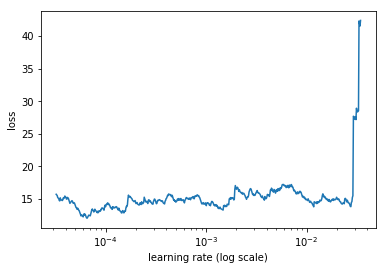

In [24]:
lr=1e-5
m.lr_find()
m.sched.plot(100)

In [25]:
lr=1e-5
m = md.get_learner(emb_szs, len(df.columns)-len(categorical_feats),
                   0.04, 1, [1000,500], [0.001,0.01])


In [26]:
m.fit(lr, 10,metrics=[exp_rmse],cycle_len=2)

epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      12.796176  15.1231    3.798062  
 47%|███████████████████████████████▍                                   | 555/1184 [00:04<00:05, 114.74it/s, loss=13.2]

KeyboardInterrupt: 

 47%|███████████████████████████████▉                                    | 555/1184 [00:20<00:22, 27.75it/s, loss=13.2]

In [58]:
x,y=m.predict_with_targs()
exp_rmse(x,y)
pred_test=m.predict(True)
pred_test = np.exp(pred_test)
df_test[dep]=pred_test

In [59]:
len(df_test)

123623

In [60]:
df_test.to_csv(f'{PATH}\submit_elov1.csv',columns=['card_id','target'],index=False)